## Setup

In [3]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [10]:
from tapas_gmm.policy.models.tpgmm import ModelType, FittingStage, InitStrategy, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.viz.gmm import plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

print(data_root)
np.set_printoptions(precision=2)

plt.style.use('default')

from matplotlib import rc
rc('animation', html='jshtml')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jangruhnert/Projects/TapasCalvin/data


In [11]:
task = 'OpenDrawer'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)


2025-02-09 00:18:46.131 | INFO     |      Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/OpenDrawer/demos/metadata.json
2025-02-09 00:18:46.136 | INFO     |      Extracted gt object labels [81, 83, 88, 93]
2025-02-09 00:18:46.137 | INFO     |      Extracted tsdf object labels []
2025-02-09 00:18:46.137 | INFO     |      Done! Data contains 5 trajectories.


In [12]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'base',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [26]:
observations = scene_data.get_demos(**gt_pose_config, indeces=[0, 2, 3, 4])

n_obs = len(observations)
print(f'Loaded {n_obs} observations')
print(observations[0].shape)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)

Loaded 4 observations
torch.Size([103])


In [15]:
tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,

    add_gripper_action=True,

    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,

    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,

    em_steps=1,

    trans_cov_mask_t_pos_corr = False,

    fix_first_component=True,
    fix_last_component=True,

    reg_init_diag=1e-4,  # 5

    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.49,
    use_bic=False,

    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,

    repeat_final_step=0,
    repeat_first_step=0,

    components_prop_to_len=True,

    min_n_components=5,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)


In [16]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-02-09 00:19:22.903 | INFO     |    Fitting AutoTPGMM
2025-02-09 00:19:22.903 | INFO     |    Segmenting trajectories


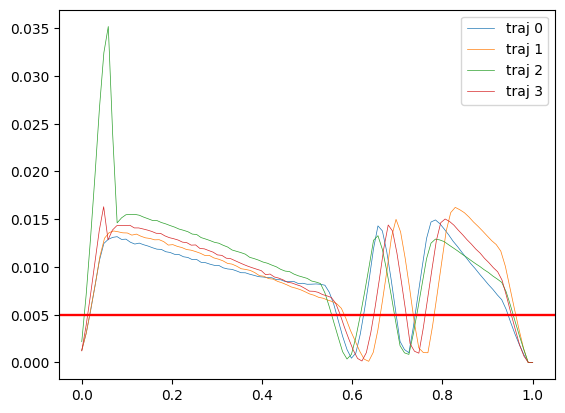

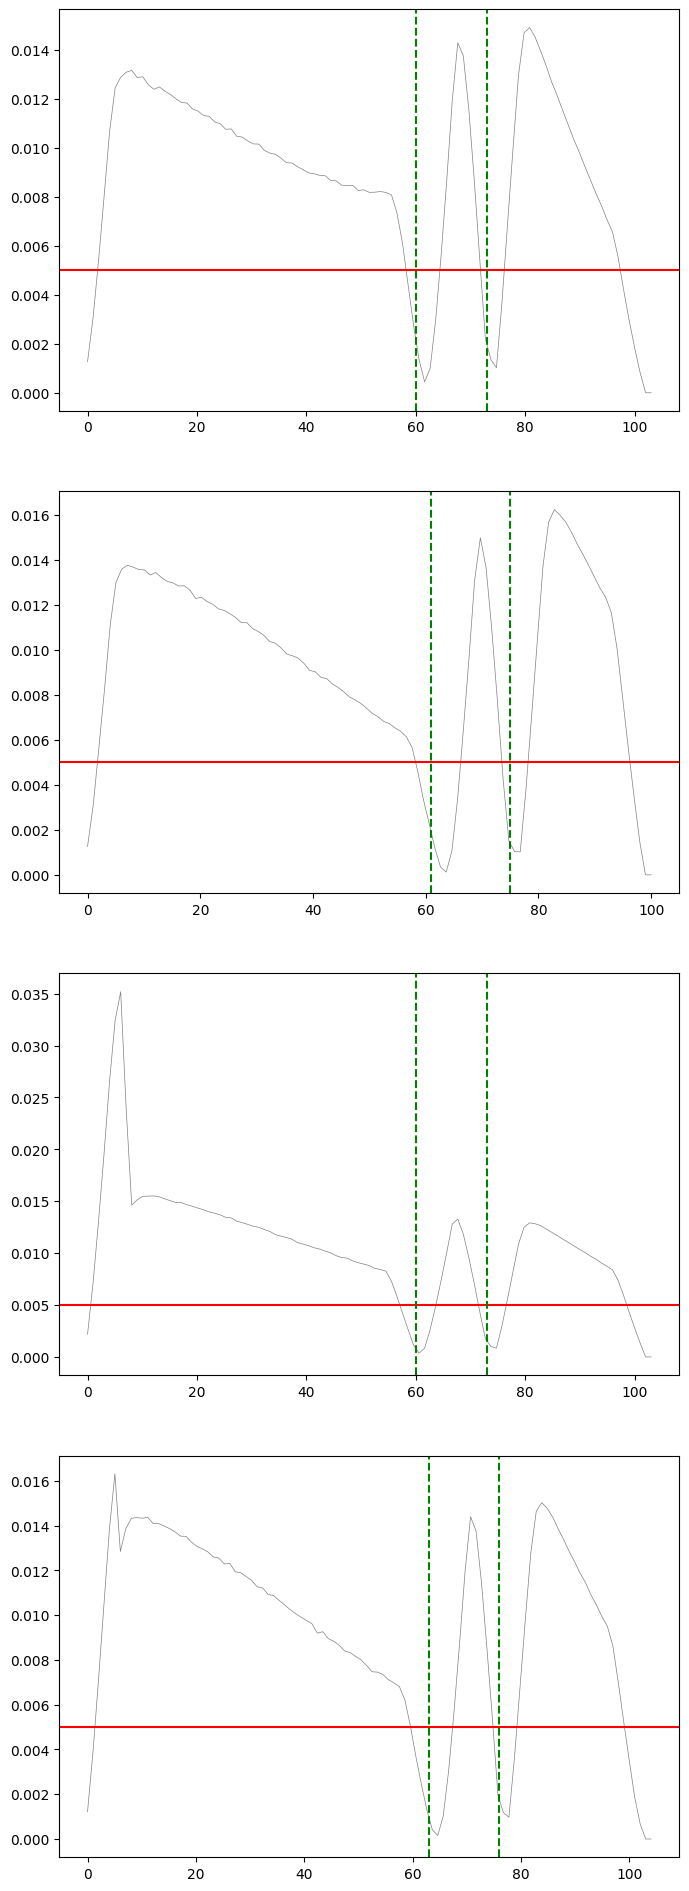

2025-02-09 00:19:23.838 | INFO     |    Creating segement of demos.
2025-02-09 00:19:23.842 | INFO     |    Creating segement of demos.
2025-02-09 00:19:23.847 | INFO     |    Creating segement of demos.
2025-02-09 00:19:23.852 | INFO     |    ... created 3 segments
2025-02-09 00:19:23.852 | INFO     |      Fitting candidate frame 1/2
2025-02-09 00:19:23.853 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2025-02-09 00:19:24.431 | INFO     |      Fitting candidate frame 2/2
2025-02-09 00:19:24.431 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

2025-02-09 00:19:25.051 | INFO     |    Creating partial frame view of demos.
2025-02-09 00:19:25.054 | INFO     |      Fitting candidate frame 1/2
2025-02-09 00:19:25.054 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-02-09 00:19:25.265 | INFO     |      Fitting candidate frame 2/2
2025-02-09 00:19:25.265 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-02-09 00:19:25.440 | INFO     |    Creating partial frame view of demos.
2025-02-09 00:19:25.443 | INFO     |      Fitting candidate frame 1/2
2025-02-09 00:19:25.444 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-02-09 00:19:25.680 | INFO     |      Fitting candidate frame 2/2
2025-02-09 00:19:25.680 | INFO     |      Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-02-09 00:19:25.961 | INFO     |    Creating partial frame view of demos.
2025-02-09 00:19:25.964 | INFO     |    Segmented trajs into 3 segments
2025-02-09 00:19:25.971 | INFO     |    Frame score (abs):
            ee_init    obj000
Segment 0 -0.998689 -0.997889
Segment 1 -0.002418 -0.998584
Segment 2 -0.002543 -0.998734
2025-02-09 00:19:25.974 | INFO     |    Frame score (rel):
            ee_init    obj000
Segment 0  1.000000  0.999198
Segment 1  0.002421  1.000000
Segment 2  0.002546  1.000000


Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/11 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

((array([[2.25e+19, 2.15e+19, 5.13e+18, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.02e+16, 4.98e+16, 1.35e+17, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.57e+09, 2.21e+10, 2.03e+11, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 2.51e+10, 9.12e+08, 5.40e+07],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 4.32e+17, 1.58e+17, 5.01e+16],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 7.69e+18, 1.14e+19, 6.80e+18]]),
  array([[8.89e+11, 9.38e+11, 3.71e+11, 6.09e+10, 3.78e+09, 6.87e+07,
          2.19e+05, 5.16e+01, 4.18e-04, 2.37e-10, 3.82e-17, 6.77e-24,
          3.69e-30, 7.59e+11, 9.46e+11, 3.77e+11, 6.16e+10, 4.08e+09,
          1.00e+08, 6.64e+05, 1.88e+01, 6.91e-05, 2.46e-11, 4.15e-18,
          1.20e-24, 1.55e-30, 9.23e+11, 9.02e+11, 3.71e+11, 5.82e+10,
          2.90e+09, 3.16e+07, 4.15e+04, 2.86e+00, 1.19e-05, 8.62e-12,
          3.30e-18, 1.61e-24, 2.01e-30, 9.46e+11, 9.07e+11, 3.68e+11,
          6.07e+10, 3.77e+09, 6.81e+07

In [18]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-02-09 00:19:44.792 | INFO     |    Did not specify time_based, deciding automatically.
2025-02-09 00:19:45.009 | WARNING  |    Skippig NaN Gaussians.


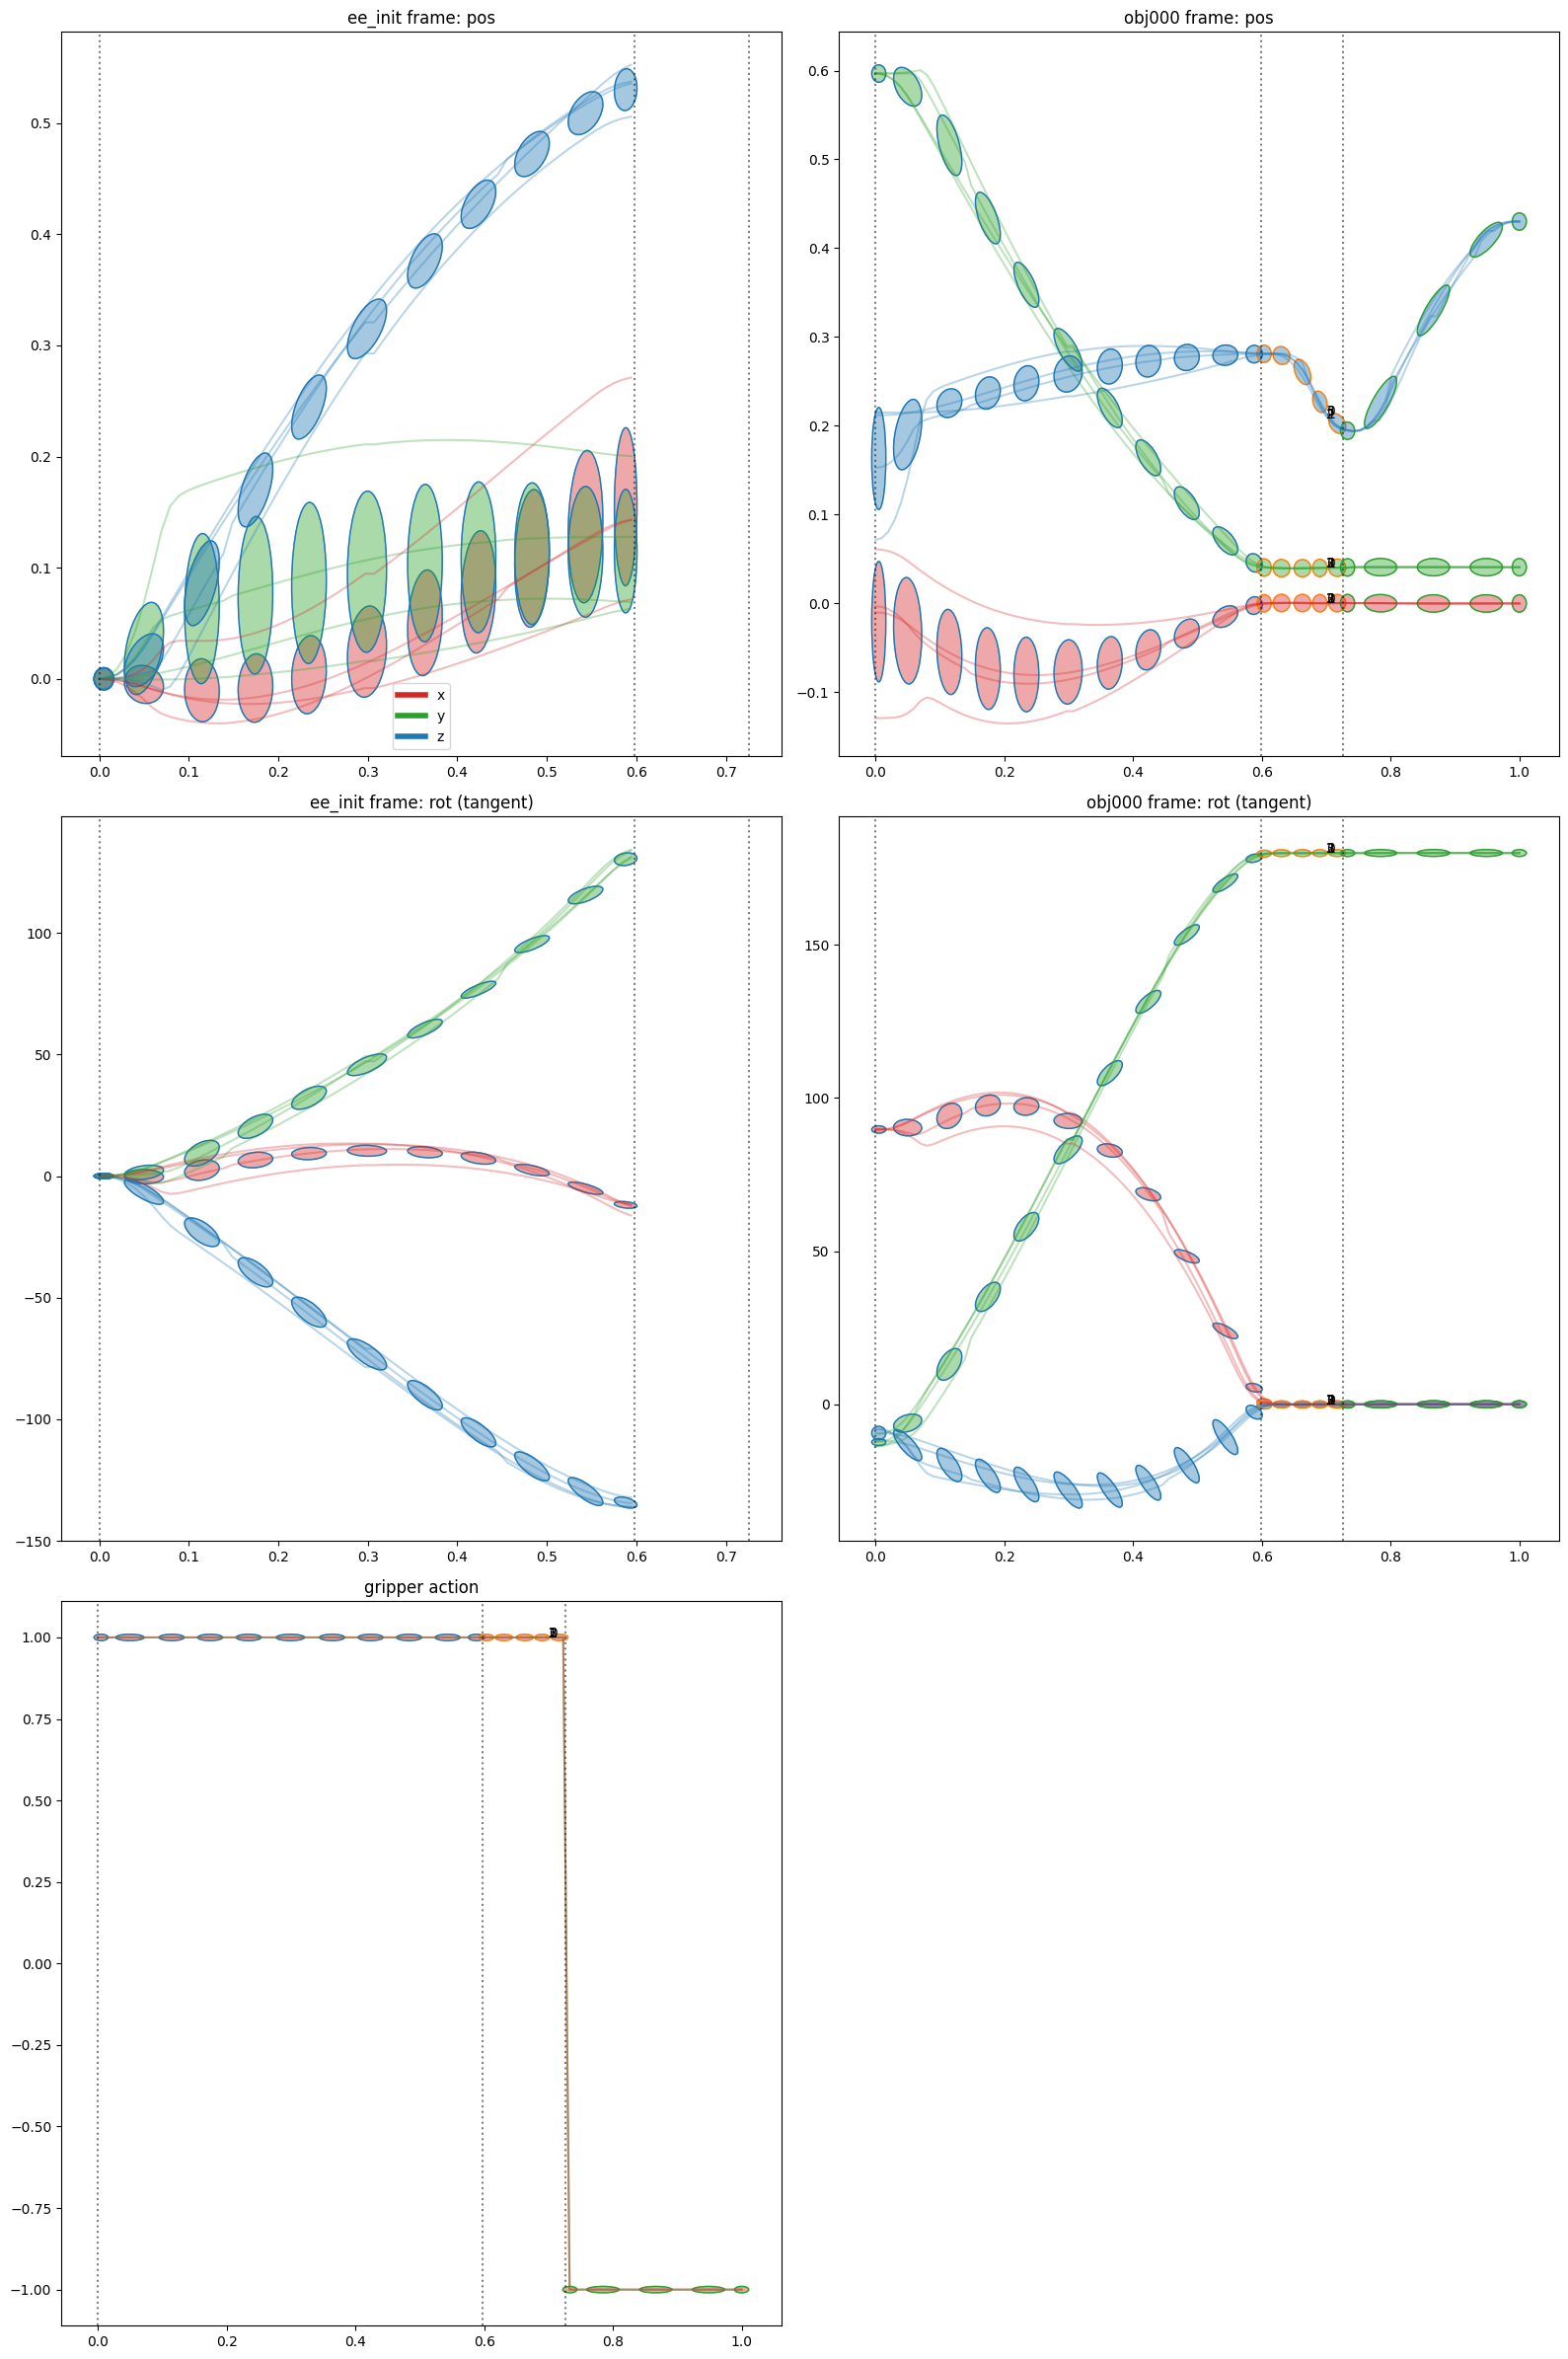

In [19]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [20]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-02-09 00:19:58.291 | INFO     |    Fitting AutoTPGMM
2025-02-09 00:19:58.291 | INFO     |    Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

2025-02-09 00:19:58.306 | INFO     |    HMM EM ...
2025-02-09 00:19:58.326 | INFO     |    HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-09 00:19:58.523 | INFO     |    HMM init priors not defined, initializing to uniform
2025-02-09 00:20:00.985 | WARNING  |    HMM EM did not converge


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[1.00e+00, 9.98e-01, 9.74e-01, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [4.53e-04, 2.31e-03, 2.57e-02, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [6.98e-11, 1.03e-09, 3.85e-08, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 3.09e-09, 7.86e-11, 7.89e-12],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 5.32e-02, 1.36e-02, 7.32e-03],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 9.47e-01, 9.86e-01, 9.93e-01]]),
  array([[9.65e-01, 7.93e-01, 3.54e-01, 5.91e-02, 4.44e-03, 9.91e-05,
          2.94e-07, 8.81e-11, 5.28e-16, 2.55e-22, 4.94e-29, 7.45e-36,
          5.94e-42, 9.71e-01, 8.02e-01, 3.58e-01, 6.06e-02, 4.97e-03,
          1.61e-04, 1.11e-06, 3.25e-11, 7.83e-17, 2.80e-23, 5.29e-30,
          1.36e-36, 2.56e-42, 9.52e-01, 7.82e-01, 3.53e-01, 5.69e-02,
          3.71e-03, 4.84e-05, 6.00e-08, 5.24e-12, 1.31e-17, 1.03e-23,
          4.22e-30, 1.81e-36, 3.29e-42, 9.54e-01, 7.83e-01, 3.52e-01,
          5.89e-02, 4.43e-03, 9.82e-05

2025-02-09 00:20:11.089 | INFO     |    Did not specify time_based, deciding automatically.


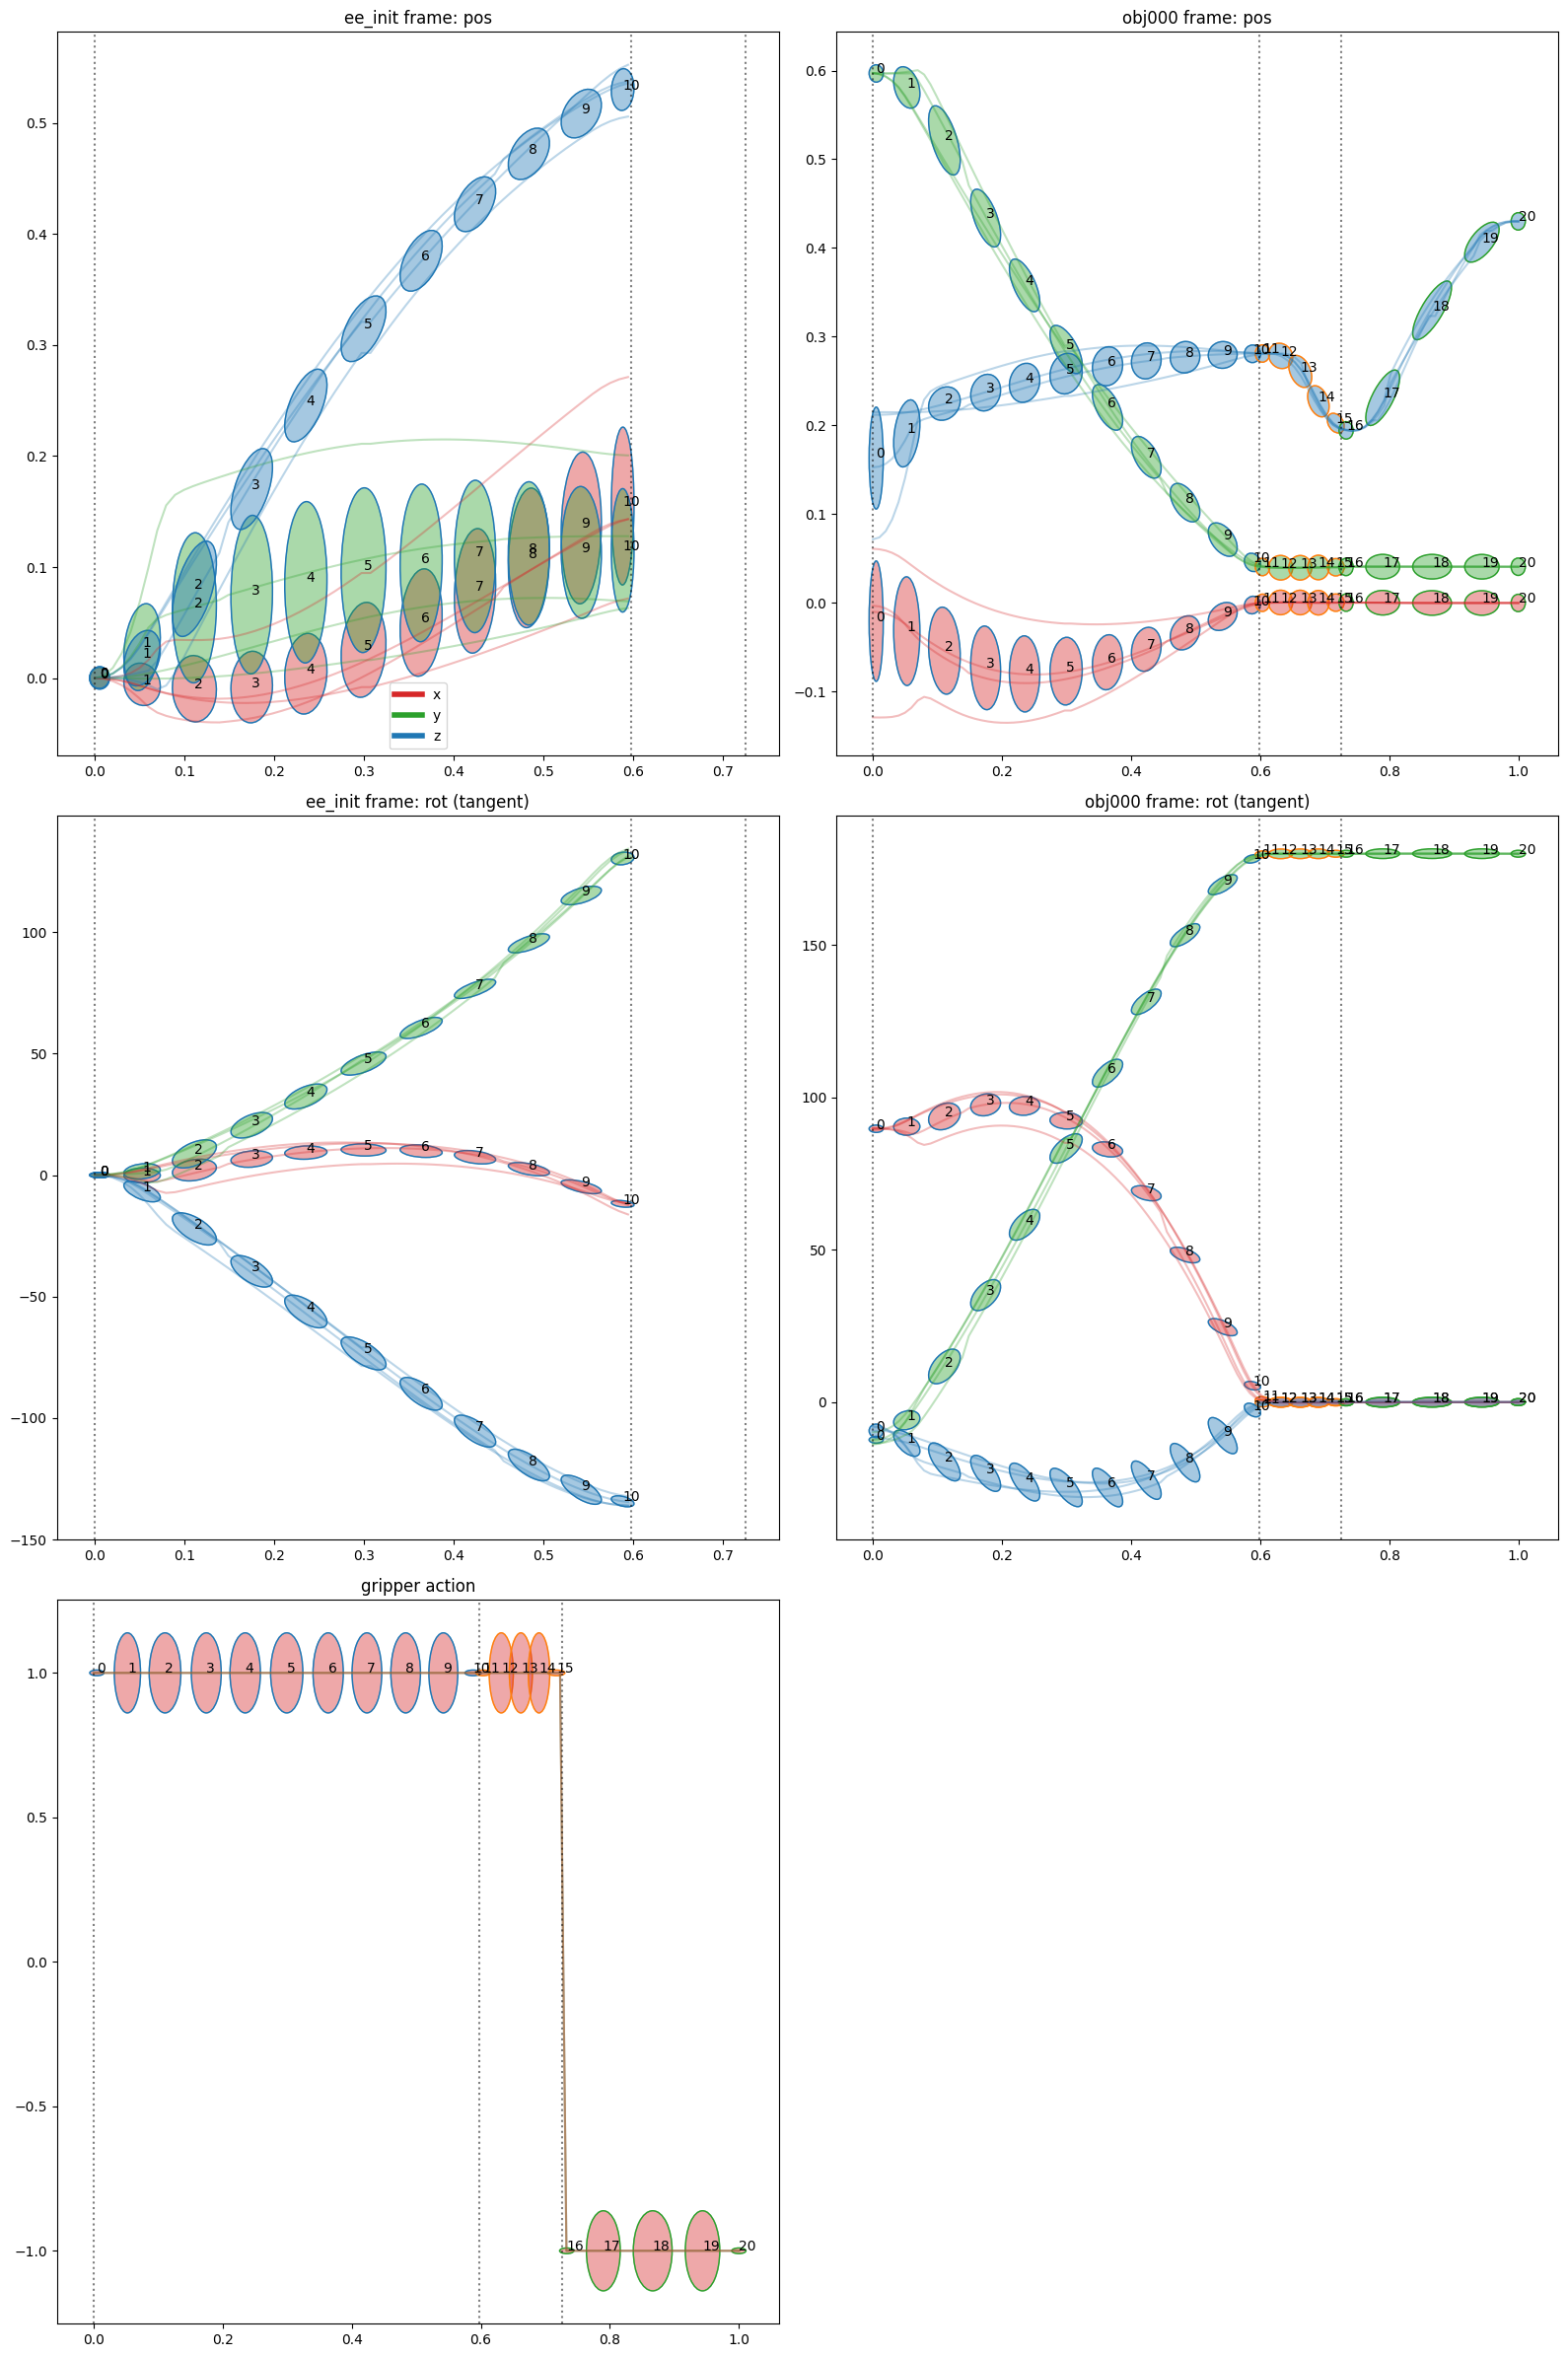

In [21]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

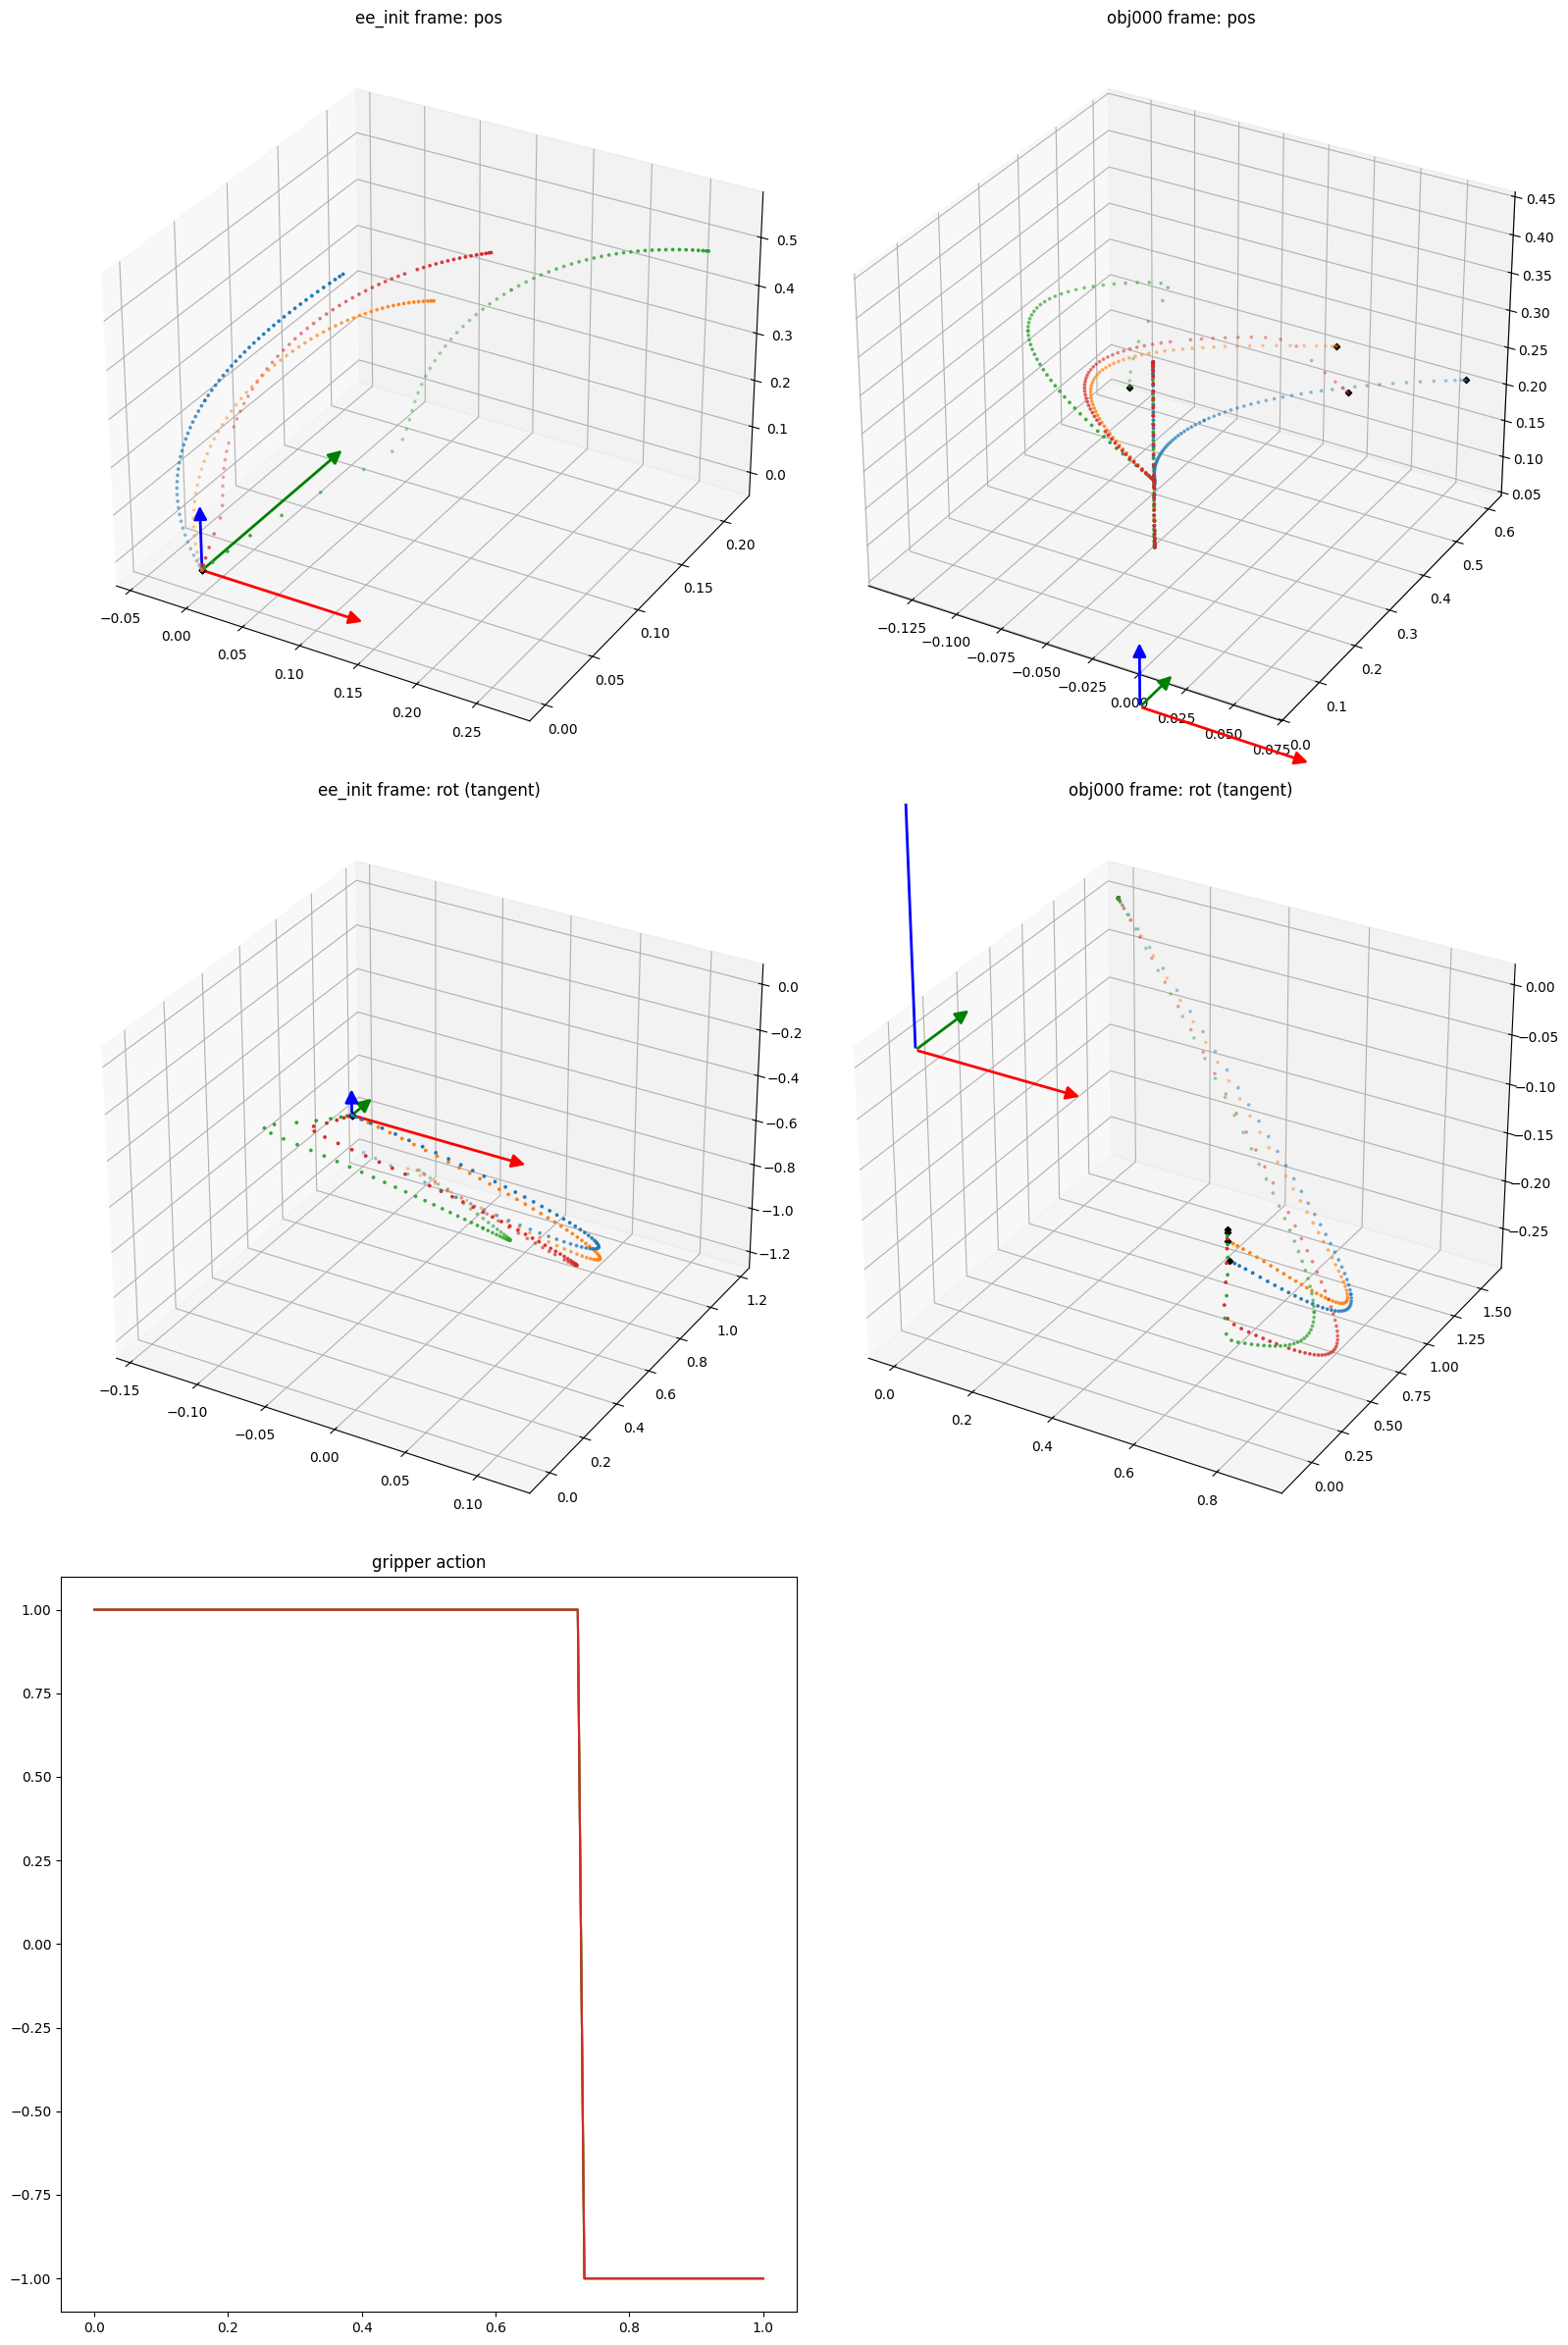

In [22]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

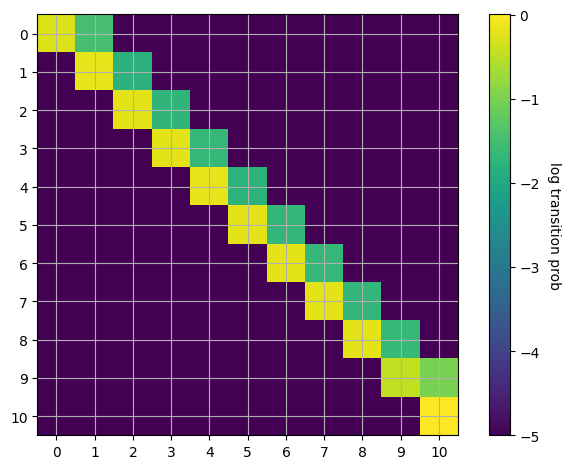

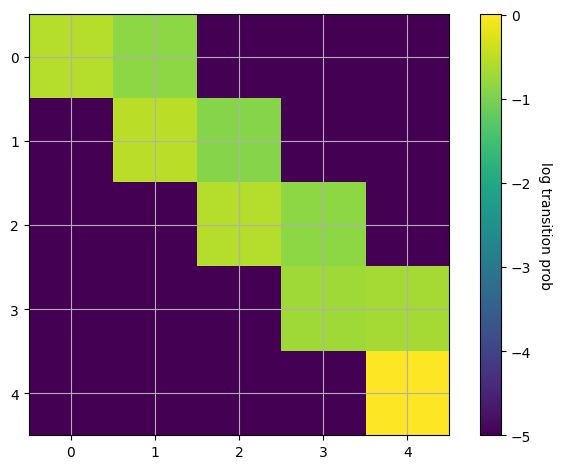

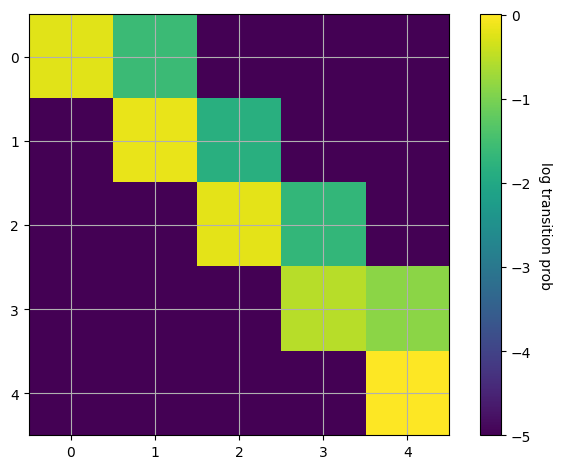

In [23]:
atpgmm.plot_hmm_transition_matrix()

In [24]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2025-02-09 00:20:38.281 | INFO     |    Saving model:


In [25]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-02-09 00:20:47.843 | INFO     |    Time-based reconstruction not specified. Auto selected True.
2025-02-09 00:20:47.910 | INFO     |    Caculated segment transition probabilities: (array([[0.84]]), array([[0.7]]))
2025-02-09 00:20:47.910 | INFO     |    Creating partial frame view of demos.
2025-02-09 00:20:47.972 | INFO     |    Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

AttributeError: module 'riepybdlib' has no attribute 'Quaternion'

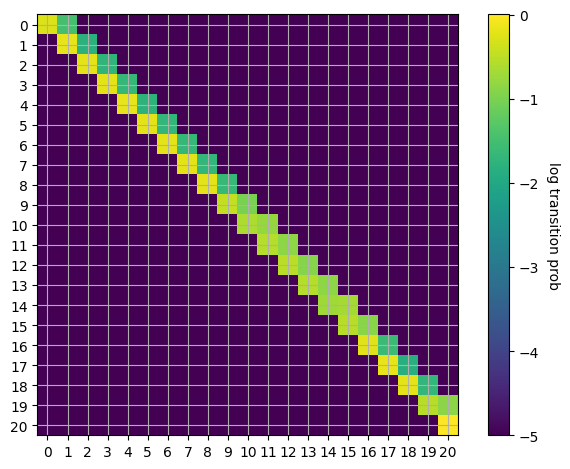

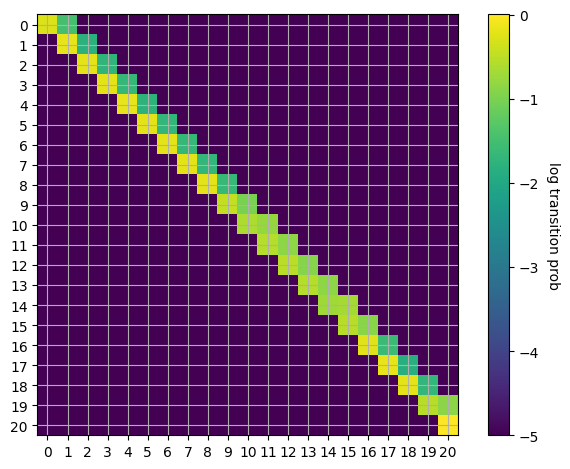

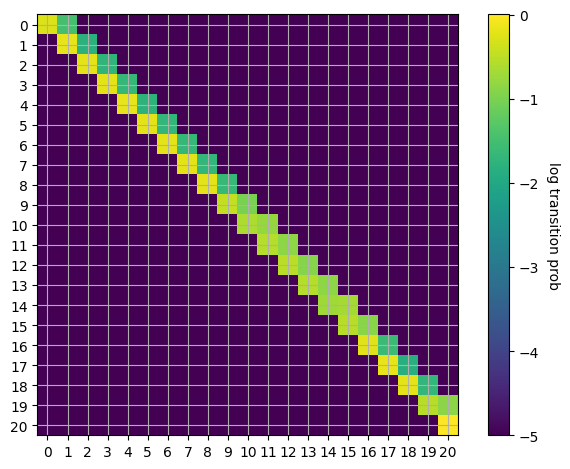

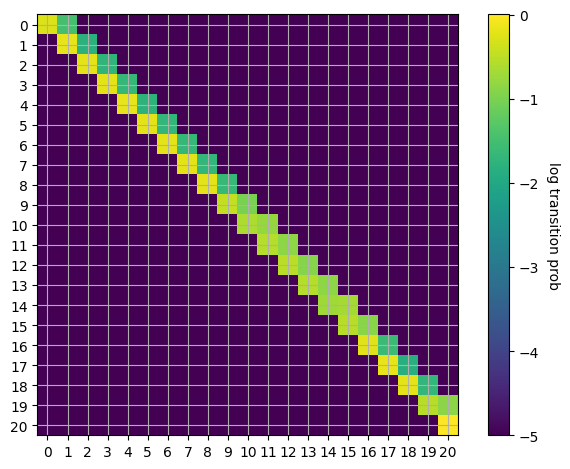

In [17]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2024-08-14 13:10:04.583 | INFO     |  Taking frame origins from demos.


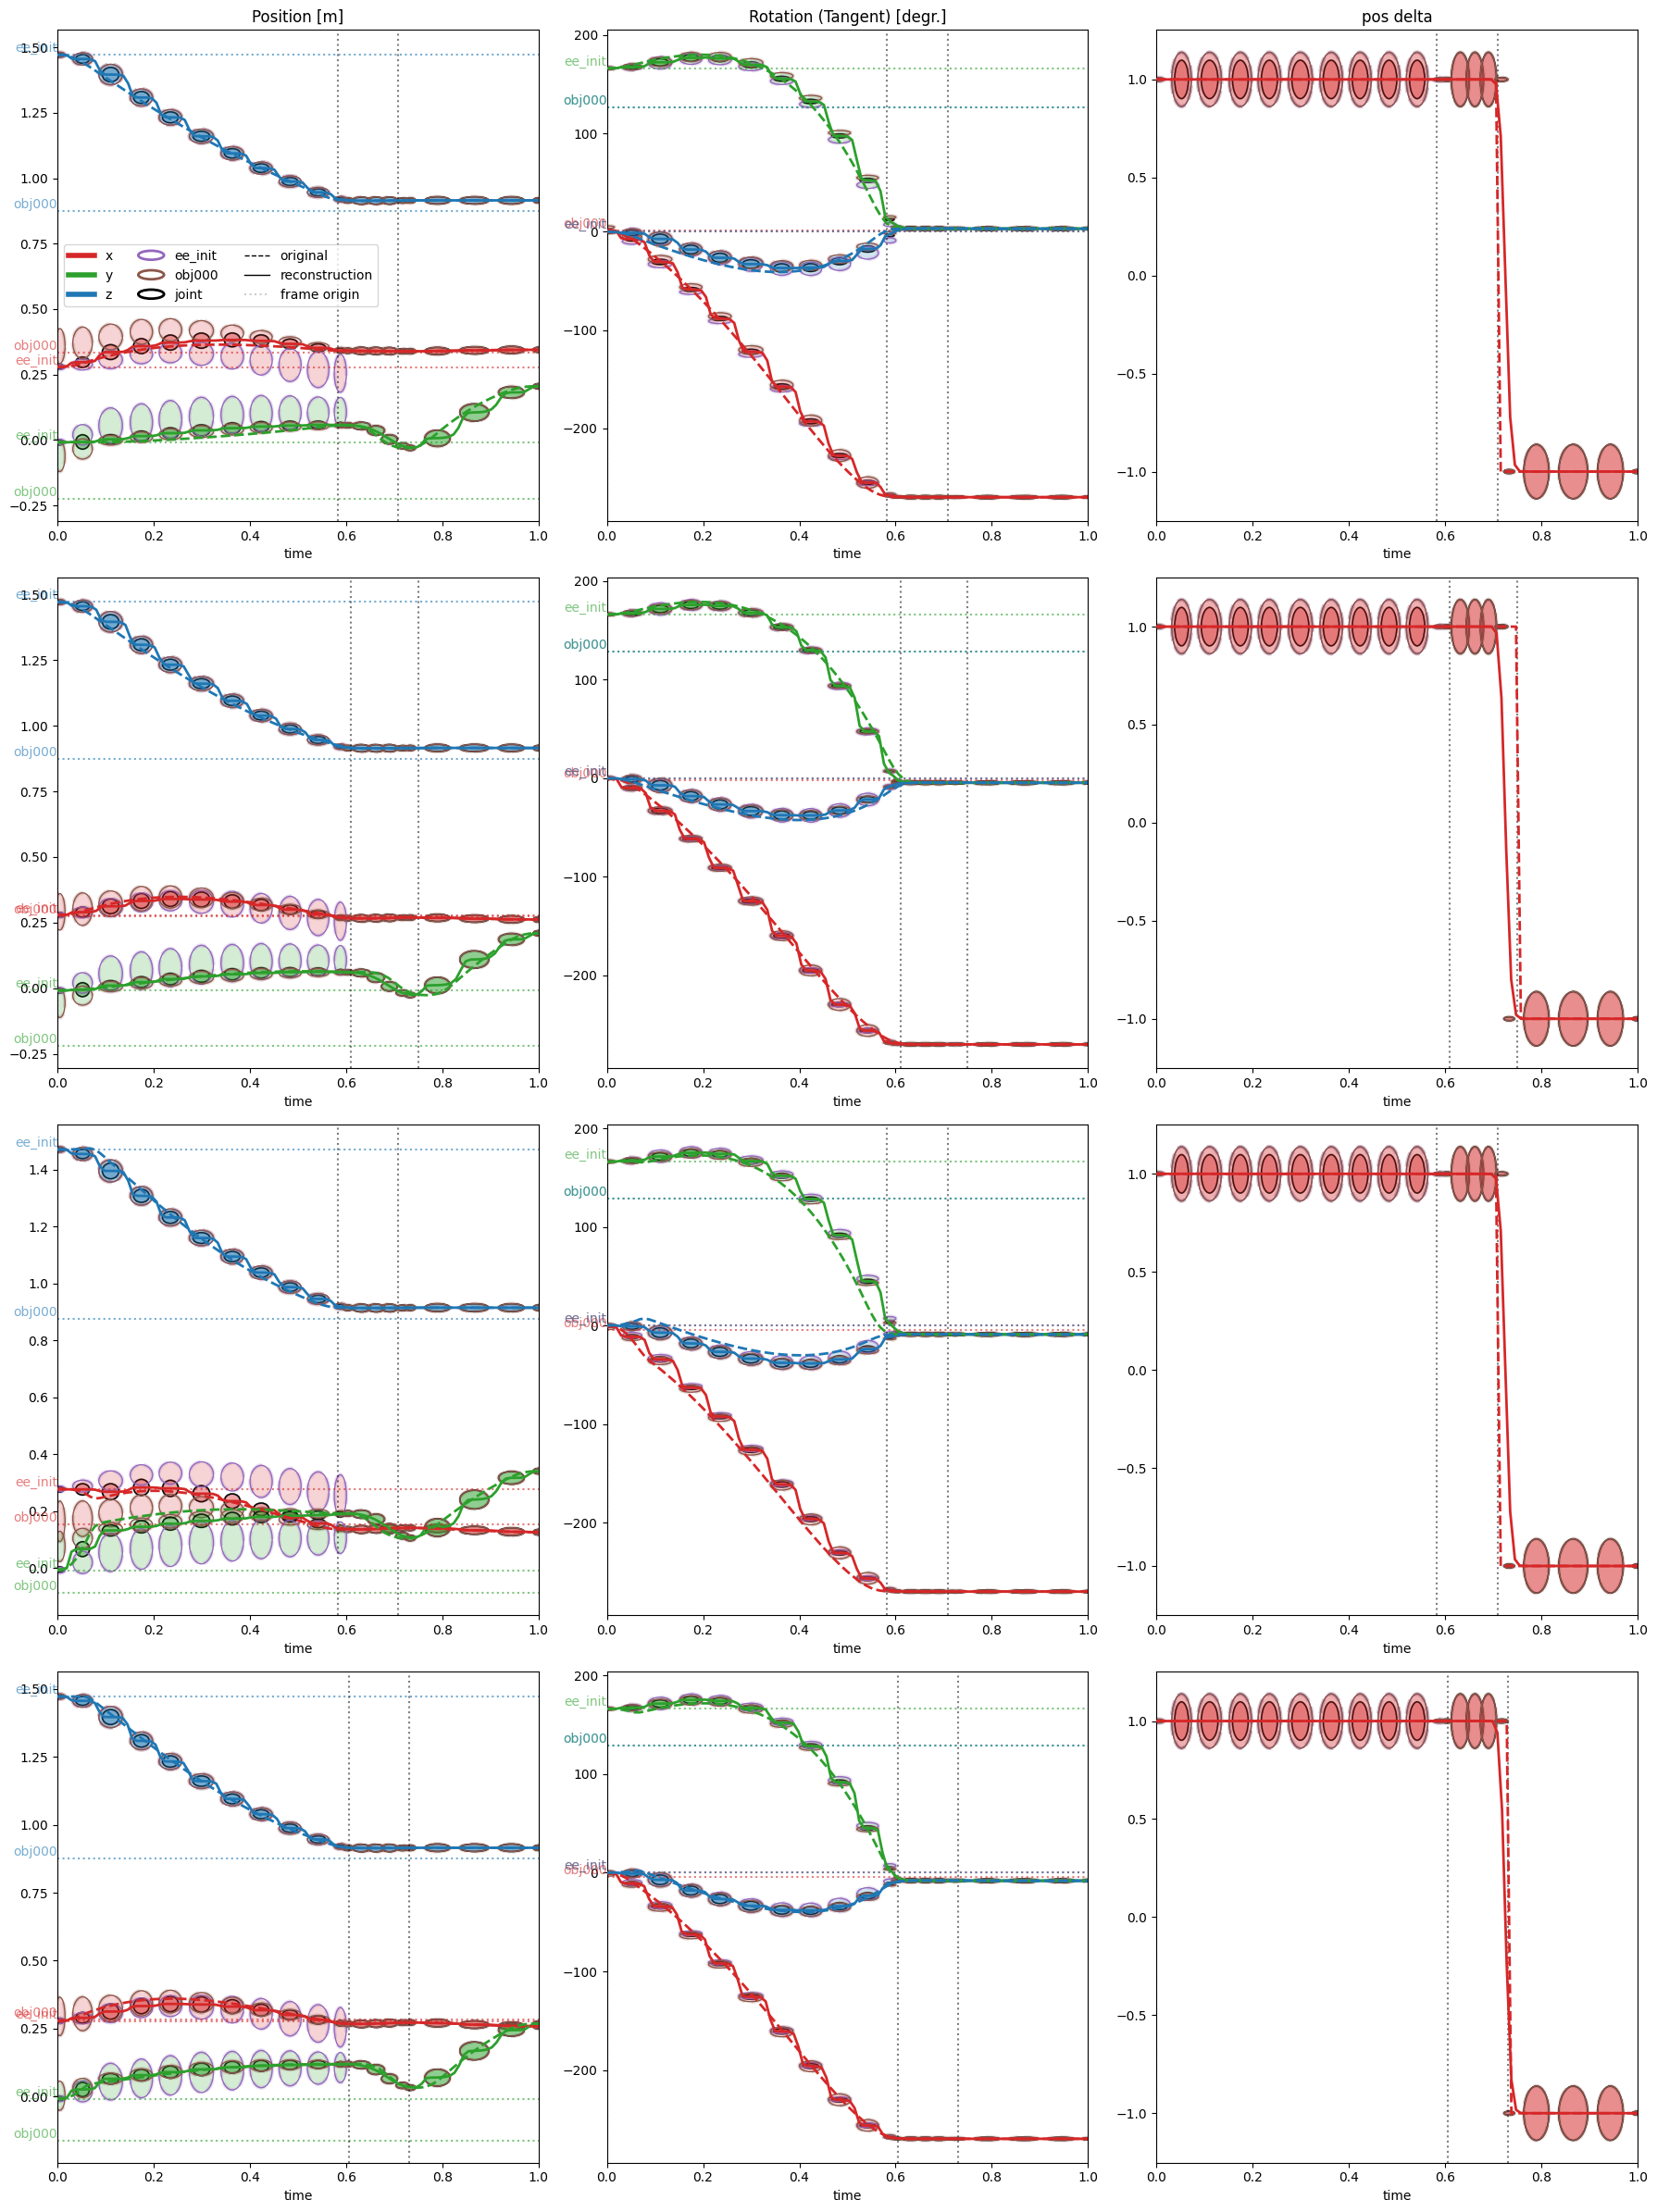

In [18]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


2024-08-14 13:10:19.125 | WARNING  |  Model uses moving frames. Can only plot one at a time. Plotting the one from the first time step.


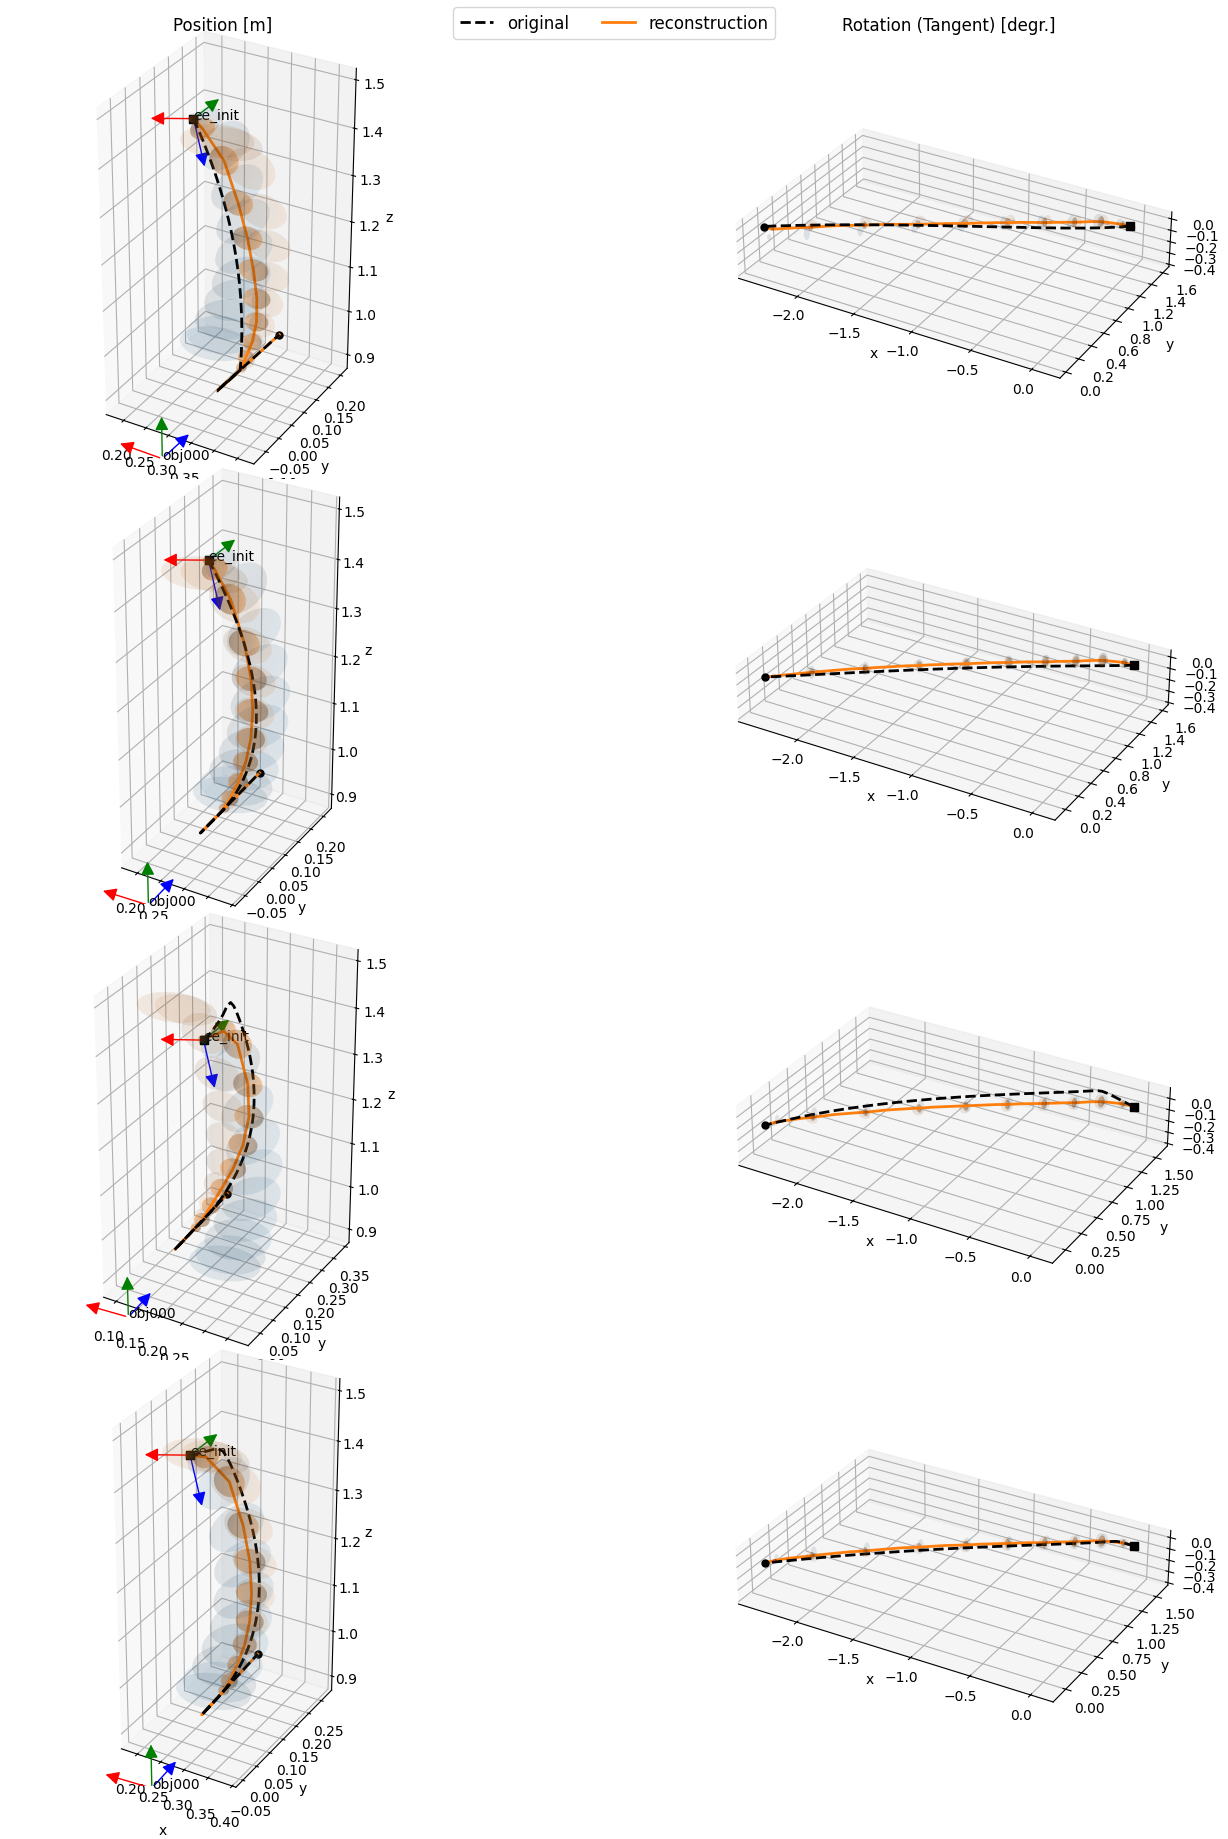

In [19]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)
